## **Import Libraries**

In [2]:
import mne

# Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

from utilities import read_xdf, epoching

np.random.seed(42)

In [35]:
# Train model
from collections import OrderedDict
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from datetime import timedelta
import keras
from keras.models import load_model
import os
from keras.utils import plot_model

# Build model
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,LSTM, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D
from keras.layers import Concatenate, Lambda, Reshape, RepeatVector,Multiply, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K                                                          
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

# Classifications report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay ,multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedShuffleSplit

## **Load Data**

### From XDF file

In [4]:
annotations_des = {
    '1': 'Left cue start',
    '2': 'Left stimuli start',
    '3': 'Left blank start',
    '4': 'Right cue start',
    '5': 'Right stimuli start',
    '6': 'Right blank start',
}

In [5]:
from utilities import read_xdf, epoching

filenames = {'Pipo_1_5_test1.xdf', 'Pipo_1_5_test2.xdf', 'Pipo_1_5_test3.xdf'}

X, F, t, y = [],[],[],[]
for filename in filenames:

    raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0))

    epochs = epoching(raw, show_psd=False,
        show_eeg=False,  # set True if wanna see preview of all epoch
        tmax=5)         # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X.append((  epochs.get_data() * 1e6)[:,:,:1250]) # select only first 1250 frames(approx 5 second)
    F.append(   epochs.compute_psd(method='welch', fmax=30).get_data())
    t.append((  epochs.times)[:1250])                # select only first 1250 frames(approx 5 second)
    y.append(   epochs.events[:, -1])

    epochs = epoching(raw, show_psd=False,
        show_eeg=False,  # set True if wanna see preview of all epoch
        baseline=(5,10),
        tmin=5,
        tmax=10)         # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X.append((  epochs.get_data() * 1e6)[:,:,:1250]) # select only first 1250 frames(approx 5 second)
    F.append(   epochs.compute_psd(method='welch', fmax=30).get_data())
    t.append((  epochs.times)[:1250])                # select only first 1250 frames(approx 5 second)
    y.append(   epochs.events[:, -1])

# Concatenate all data
X = np.concatenate(X)
F = np.concatenate(F)
t = np.concatenate(t)
y = np.concatenate(y)

Creating RawArray with float64 data, n_channels=8, n_times=50520
    Range : 0 ... 50519 =      0.000 ...   201.994 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.651 sec)

Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1252 original time points ...
0 bad epochs dropped
Effective window size : 1.024 (s)
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
1 bad epochs dropped
Effective window size : 1.024 (s)
Creating RawArray with float64 data, n_channels=8, n_times=49650
    Range : 0 ... 49649 =      0.000 ...   198.521 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=8, n_times=52020
    Range : 0 ... 52019 =      0.000 ...   208.006 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.651 sec)

Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
Effective window size : 1.024 (s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [6]:
X.shape, F.shape, t.shape, y.shape

((96, 5, 1250), (96, 5, 31), (7500,), (96,))

In [9]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y = enc.fit_transform(y.reshape(-1, 1)).toarray()
# Y = y.copy()
# mp = {2:0, 5:1}
# for i in range(len(Y)):
#     Y[i] = mp[Y[i]]

In [10]:
X.shape, F.shape, t.shape, Y.shape

((96, 5, 1250), (96, 5, 31), (7500,), (96, 2))

### From CSV file

In [27]:
# Load data
df = pd.read_csv('data/epochs.csv')

# Split data into training and testing sets
train_dataset = df.sample(frac=0.9,random_state=0)
test_dataset = df.drop(train_dataset.index).sample(frac=1.0,random_state=0)

train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

train_dataset

,time,condition,epoch,obci_eeg1_1,obci_eeg1_2,obci_eeg1_3,obci_eeg1_4,obci_eeg1_5,label
0,4.842162,2,46,6.016688e+06,5.907060e+05,2.317239e+06,5.115647e+06,3.348605e+06,left
1,4.986108,5,43,6.081990e+06,2.973919e+06,1.753824e+06,2.425596e+06,7.638529e+05,right
2,1.311467,2,13,9.685057e+06,1.466573e+07,9.169258e+06,5.183600e+06,9.104924e+05,left
3,5.813636,2,13,8.779035e+06,1.110653e+07,8.347606e+06,5.236361e+06,3.550461e+05,left
4,9.672068,2,13,-4.624806e+06,-4.530194e+06,-6.800515e+06,-2.772920e+06,1.029761e+06,left
...,...,...,...,...,...,...,...,...,...
108081,5.097927,2,34,-1.117426e+07,-2.705433e+06,-8.613340e+06,-1.000741e+07,-7.874929e+06,left
108082,5.529901,2,34,6.952308e+06,-2.049482e+06,-1.450021e+06,1.313311e+06,3.384785e+06,left
108083,0.679771,5,25,-2.051936e+07,-1.583086e+07,-1.313489e+07,-9.706165e+06,-1.305043e+06,right
108084,5.409947,5,16,9.557269e+06,7.150896e+06,7.376946e+06,1.495488e+07,1.600492e+07,right


## **Cross-validation**: evaluating estimator performance

💡 [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) |
[scikeras](https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/)

### 5-different machine learning pipelines

💡 [EEG Notebook](https://neurotechx.github.io/eeg-notebooks/auto_examples/visual_ssvep/02r__ssvep_decoding.html)

In [ ]:
# Next, we will use 5 different machine learning pipelines to classify the SSVEP based on the data we collected. The

# - CSP + RegLDA : Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
# - Cov + TS : Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
# - Cov + MDM: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
# - CSP + Cov + TS: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand
# - CNN: 

# Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

# Note: because we're doing machine learning here, the following cell may take a while to complete

clfs = OrderedDict()
clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

from models import CNNModel
from scikeras.wrappers import KerasClassifier

CNN = CNNModel()
clfs['CNN'] = KerasClassifier(model=CNN.get_model(), epochs=10, batch_size=8, verbose=0)

# define cross validation
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25,
                                        random_state=42)
scoring = {'acc': 'accuracy',
           'auc': 'roc_auc'}

# run cross validation for each pipeline
acc,auc = [],[]
methods = []
for m in tqdm(clfs):
    # print(m)
    res = cross_validate(clfs[m], X, y, scoring=scoring, cv=cv, n_jobs=-1)
    # res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    '''res = {'fit_time': array([3.94812942, 3.98712373, 3.819134  , 3.88912916]),
              'score_time': array([0.53296137, 0.5869596 , 0.53796363, 0.6069591 ]),
              'test_acc': array([1.        , 0.95833333, 1.        , 1.        ]),
              'test_auc': array([1., 1., 1., 1.])}'''
    acc.extend(res['test_acc'])
    auc.extend(res['test_auc'])
    methods.extend([m]*len(res['score_time']))

# res = cross_val_score(clfs_CNN, X, y, scoring='roc_auc',cv=cv, n_jobs=-1)
# auc.extend(res)
# methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Accuracy'] = acc
results['Method'] = methods

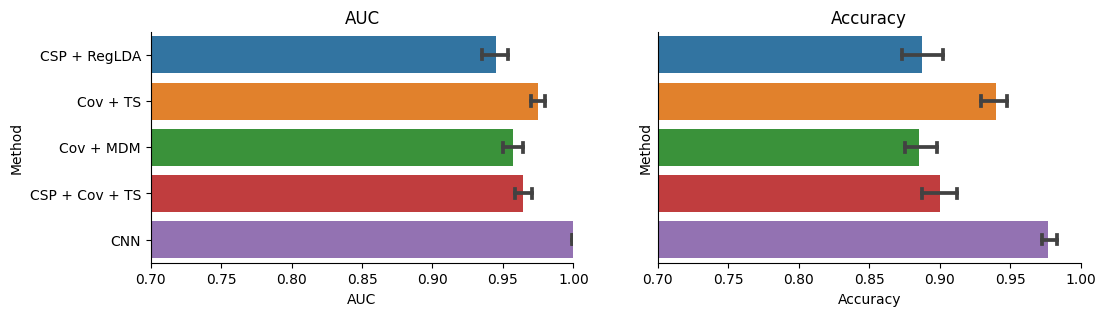

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=[12,3])
sns.barplot(data=results, x='AUC', y='Method', capsize=.2, ax=ax[0],
        errorbar=('ci', 68),
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
ax[0].set_xlim(0.7, 1); ax[0].set_title('AUC')
sns.despine()

# fig, ax = plt.subplot(2, figsize=[8,4])
sns.barplot(data=results, x='Accuracy', y='Method', capsize=.2, ax=ax[1],
        errorbar=('ci', 68),
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
ax[1].set_xlim(0.7, 1); ax[1].set_title('Accuracy'); ax[1].set_yticks([])
sns.despine()
plt.show()

## **Training pipeline**

### Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [30]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [31]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train_CNN = tf.convert_to_tensor(X_train_CNN, dtype=tf.float32)
X_test_CNN = tf.convert_to_tensor(X_test_CNN, dtype=tf.float32)
y_train_CNN = tf.convert_to_tensor(y_train_CNN, dtype=tf.int32)
y_test_CNN = tf.convert_to_tensor(y_test_CNN, dtype=tf.int32)

### **Create a model**

In [32]:
from models import CNNModel

In [33]:
CNN = CNNModel()
CNN.model.summary()

Model: "CNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 1250)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 128)            480128    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 3, 128)           512       
 malization)                                                     
                                                                 
 maxpool_layer1 (MaxPooling1  (None, 1, 128)           0         
 D)                                                              
                                                                 
 dropout_layer1 (Dropout)    (None, 1, 128)            0         
                                                                 
 dense_layer1 (Dense)        (None, 1, 64)             825

In [34]:
# CNN.model_train(X_train_CNN, y_train_CNN)
CNN.load_weights('CNN.h5')

In [35]:
out = CNN.model_predict_classes(X_test_CNN)

1/1 [==============================] - 0s 235ms/step


In [36]:
out

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

### **Evaluate the model**

In [37]:
predictions = CNN.model_predict(X_test_CNN)
predictions

1/1 [==============================] - 0s 21ms/step


array([[9.9398196e-01],
       [1.7566620e-06],
       [9.9983037e-01],
       [9.9998677e-01],
       [9.9923533e-01],
       [2.3322612e-04],
       [9.9896675e-01],
       [5.6743014e-05],
       [9.9638045e-01],
       [9.9990696e-01],
       [9.9713033e-01],
       [1.0051390e-05],
       [7.4121395e-05],
       [9.7766441e-01],
       [9.9996054e-01],
       [9.9975502e-01],
       [9.9908465e-01],
       [9.9992508e-01],
       [9.9993724e-01],
       [9.9831343e-01]], dtype=float32)

In [38]:
np.set_printoptions(suppress=True)
print(predictions*100)

[[99.39819   ]
 [ 0.00017567]
 [99.98304   ]
 [99.99868   ]
 [99.92353   ]
 [ 0.02332261]
 [99.896675  ]
 [ 0.0056743 ]
 [99.63805   ]
 [99.99069   ]
 [99.713036  ]
 [ 0.00100514]
 [ 0.00741214]
 [97.76644   ]
 [99.996056  ]
 [99.9755    ]
 [99.90846   ]
 [99.99251   ]
 [99.99372   ]
 [99.831345  ]]


In [39]:
# threshold x <= 0.2 -> 0 , x > 0.8 -> 1
temp = []
for pred in predictions:
    if pred <= 0.2:
        temp.append(0)
    elif pred >= 0.8:
        temp.append(1)
    else:
        temp.append(-1)


In [40]:
temp

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [41]:
# # Convert predictions to binary
# predictions = np.argmax(predictions, axis=1)
# predictions
# Threshold predictions
predictions = np.where(predictions > 0.5, 1, 0)
predictions

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [42]:
# # Classification report
print(classification_report(y_test_CNN, predictions))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.93      1.00      0.97        14

    accuracy                           0.95        20
   macro avg       0.97      0.92      0.94        20
weighted avg       0.95      0.95      0.95        20



In [43]:
# CNN.model.save('CNN.h5')